# Rice Classification with CNN (using CUDA)

dataset contains 75000 images from 5 diffrent type of rices :

1. Arborio
2. Basmati
3. Ipsala
4. Jasmine
5. Karacadag

15000 images for each class of rice

dataset : https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

### choosing device

In [1]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


### creating dataset class


In [2]:
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
from math import floor
from torchvision.transforms import Grayscale,Resize


labelsDict = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"
}

class Custom_Dataset(Dataset):
    def __init__(self,labels ,img_dir,transform=None):
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # label = labelsDict[floor(idx/15000)]
        label = self.labels[idx]
        label = label.to(device)
        img_name = labelsDict[int(label)]+" (" + str(idx -(15000*floor(idx/15000))+1) +").jpg"
        img_path = os.path.join(os.getcwd(),self.img_dir, img_name)
        image = read_image(img_path)
        # label = int(label.item())
        # image = Grayscale()(image) #remove 3 image channels
        image = Resize(size=(150,150),antialias=True)(image)
        # image = image.squeeze()
        image = image.float()
        image = image.to(device)
        if(self.transform):
            image = self.transform(image)
        return image, label
    


### creating our dataset

In [3]:
labels = torch.zeros(75000)
labels[15000:30000] = 1
labels[30000:45000] = 2
labels[45000:60000] = 3
labels[60000:75000] = 4

dataset = Custom_Dataset(labels,"Rice_Image_Dataset")

### shuffeling and creating train / test dataset

In [4]:
from torch.utils.data import Subset
import numpy as np

N = len(dataset)

indices = np.arange(N)
indices = np.random.permutation(indices)

slice = int(0.8*N)

train_indices = indices[:slice]
test_indices = indices[slice:]

train_dataset = Subset(dataset,train_indices)
test_dataset = Subset(dataset,test_indices)


### Loading Data

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=64,shuffle=True)


### creating model

In [6]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            # shape is 150 x 150 , 3 channels
            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(3,3)), # 6 , 148 , 148
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2,2)), # 6 , 74 , 74
            nn.Conv2d(in_channels=6,out_channels=9,kernel_size=(3,3)), # 9 , 72 , 72
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2,2)), # 9 , 36 , 36
            nn.Conv2d(in_channels=9,out_channels=12,kernel_size=(3,3)), # 12 , 34 , 34
            nn.ReLU(),

            nn.Flatten(), # 12*34*34
            nn.Linear(13872,5000),
            nn.ReLU(),
            nn.Linear(5000,1000),
            nn.ReLU(),
            nn.Linear(1000,5),
        ) 
        
    def forward(self,X):
        logits = self.seq(X)
        return logits

### learning

In [8]:
model = NeuralNetwork().to(device)

learning_rate = 0.0005
epoches = 5
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

losses = []

def train_loop(train_dataloader,model,loss_fn,optim):
    model.train()
    for batch, (X,y) in enumerate(train_dataloader):
        y=y.to(torch.int64)
        pred = model(X)
        loss = loss_fn(pred,y)
        losses.append(loss.item())

        loss.backward()
        optim.step()
        optim.zero_grad()

        if (batch % 100 == 0):
            loss = loss.item()
            current = (batch+1)*len(X)
            total_size = len(train_dataloader.dataset)
            print("loss : {} / [{}/{}]".format(loss,current,total_size))

def test_loop(test_dataloader,model,loss_fn):
    model.eval()
    test_loss,correct = 0,0

    with torch.no_grad():
        for X,y in test_dataloader:
            y=y.to(torch.int64)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    correct /= size # acuuracy
    test_loss /= num_batches # avg loss in each batch

    print("Test ERR >> Acc : {} / Avg Loss : {}".format(correct,test_loss))
    return correct

finalAcc = -100

for i in range(epoches):
    print("EPOCH {} -----------------------------".format(i+1))
    train_loop(train_dataloader,model,loss_fn,optimizer)
    acc = test_loop(test_dataloader,model,loss_fn)
    finalAcc = acc

print("Done, Accuracy is : {}".format(finalAcc))


EPOCH 1 -----------------------------
loss : 1.5732481479644775 / [64/60000]
loss : 0.0964936688542366 / [6464/60000]
loss : 0.017746701836586 / [12864/60000]
loss : 0.0936436727643013 / [19264/60000]
loss : 0.046339165419340134 / [25664/60000]
loss : 0.05478464439511299 / [32064/60000]
loss : 0.03699397295713425 / [38464/60000]
loss : 0.08063145726919174 / [44864/60000]
loss : 0.01355769857764244 / [51264/60000]
loss : 0.027532970532774925 / [57664/60000]
Test ERR >> Acc : 0.9858666666666667 / Avg Loss : 0.0392791764503543
EPOCH 2 -----------------------------
loss : 0.0877906009554863 / [64/60000]
loss : 0.11356529593467712 / [6464/60000]
loss : 0.022335810586810112 / [12864/60000]
loss : 0.05216651037335396 / [19264/60000]
loss : 0.060659486800432205 / [25664/60000]
loss : 0.008905455470085144 / [32064/60000]
loss : 0.02628396824002266 / [38464/60000]
loss : 0.12759432196617126 / [44864/60000]
loss : 0.005161692854017019 / [51264/60000]
loss : 0.029143324121832848 / [57664/60000]
Te

<Axes: >

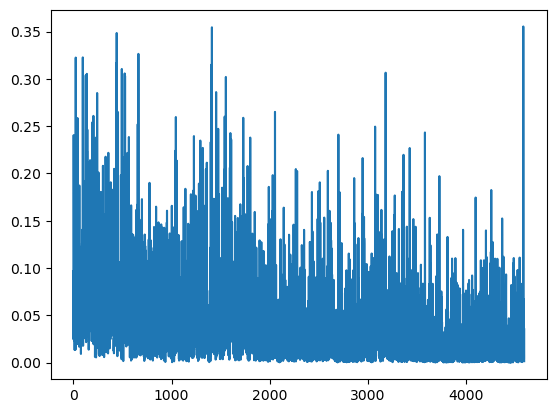

In [12]:
import seaborn as sns
sns.lineplot(losses[100:])

we are missing the minimum , it means we need a lower learning rate

In [14]:
learning_rate = 0.00005
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

epoches = 3

for i in range(epoches):
    print("EPOCH {} -----------------------------".format(i+1))
    train_loop(train_dataloader,model,loss_fn,optimizer)
    acc = test_loop(test_dataloader,model,loss_fn)
    finalAcc = acc

print("Done, Accuracy is : {}".format(finalAcc))

EPOCH 1 -----------------------------
loss : 0.001293357228860259 / [64/60000]
loss : 0.004765036050230265 / [6464/60000]
loss : 5.509679613169283e-05 / [12864/60000]
loss : 0.0011492558987811208 / [19264/60000]
loss : 0.0016818486619740725 / [25664/60000]
loss : 0.005484278313815594 / [32064/60000]
loss : 0.03618599846959114 / [38464/60000]
loss : 3.494461634545587e-05 / [44864/60000]
loss : 0.00035482709063217044 / [51264/60000]
loss : 8.408115536440164e-05 / [57664/60000]
Test ERR >> Acc : 0.9929333333333333 / Avg Loss : 0.030341232526103688
EPOCH 2 -----------------------------
loss : 0.0010458315955474973 / [64/60000]
loss : 0.00018393713980913162 / [6464/60000]
loss : 0.0700087696313858 / [12864/60000]
loss : 1.256940231542103e-05 / [19264/60000]
loss : 0.00014843253302387893 / [25664/60000]
loss : 0.004273050464689732 / [32064/60000]
loss : 0.0009329481981694698 / [38464/60000]
loss : 1.048662625180441e-06 / [44864/60000]
loss : 2.8236154321348295e-05 / [51264/60000]
loss : 3.78

<Axes: >

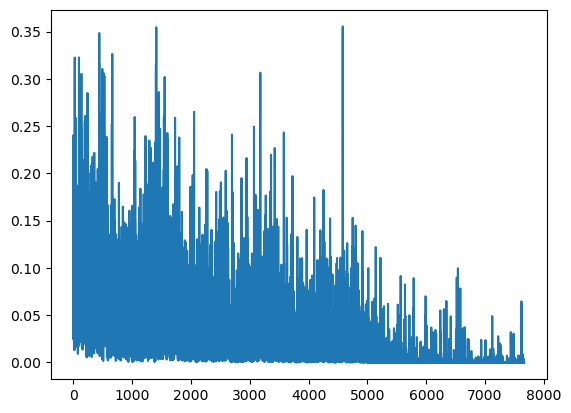

In [15]:
import seaborn as sns
sns.lineplot(losses[100:])

result is much better and it seems we are converging
lets try a lower lr

In [16]:
learning_rate = 0.000005
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

epoches = 2

for i in range(epoches):
    print("EPOCH {} -----------------------------".format(i+1))
    train_loop(train_dataloader,model,loss_fn,optimizer)
    acc = test_loop(test_dataloader,model,loss_fn)
    finalAcc = acc

print("Done, Accuracy is : {}".format(finalAcc))

EPOCH 1 -----------------------------
loss : 3.3451792660343926e-06 / [64/60000]
loss : 2.6768797397380695e-05 / [6464/60000]
loss : 2.484708829797455e-06 / [12864/60000]
loss : 0.0002293264988111332 / [19264/60000]
loss : 3.665557642307249e-06 / [25664/60000]
loss : 2.1024410671088845e-05 / [32064/60000]
loss : 1.2535331279650563e-06 / [38464/60000]
loss : 1.1790173175540986e-06 / [44864/60000]
loss : 8.847513299770071e-07 / [51264/60000]
loss : 5.842600330652203e-06 / [57664/60000]
Test ERR >> Acc : 0.9941333333333333 / Avg Loss : 0.03807215285061825
EPOCH 2 -----------------------------
loss : 8.400397746299859e-07 / [64/60000]
loss : 1.893255830509588e-05 / [6464/60000]
loss : 0.003994577098637819 / [12864/60000]
loss : 2.698762045838521e-06 / [19264/60000]
loss : 0.00013651989866048098 / [25664/60000]
loss : 8.512220119882841e-07 / [32064/60000]
loss : 2.0675290102190047e-07 / [38464/60000]
loss : 6.109444257162977e-07 / [44864/60000]
loss : 7.338682053159573e-07 / [51264/60000]
l

<Axes: >

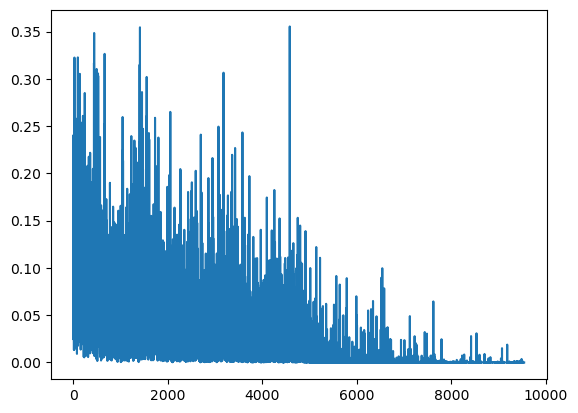

In [17]:
import seaborn as sns
sns.lineplot(losses[100:])

<Axes: >

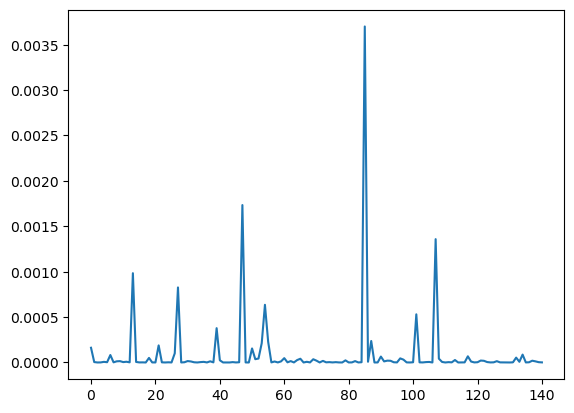

In [19]:
import seaborn as sns
sns.lineplot(losses[9500:])

we are likely converging but jumping from minimum is still visible at some points 

resulted with accuracy **99.4%**<br>